### Install & Import Dependencies

In [41]:
%pip install flappy-bird-gymnasium
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:
import numpy as np
from collections import defaultdict
import pickle
import gzip

import flappy_bird_gymnasium
import gymnasium

import matplotlib.pyplot as plt
from tqdm import tqdm

### Q-Learning Agent

In [43]:
class QLearningAgent:
    def __init__(
        self,
        learning_rate: float = None,
        initial_epsilon: float = 0.0,
        epsilon_decay: float = None,
        final_epsilon: float = None,
        discount_factor: float = 0.95,
        env: gymnasium.Env = None,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(self.env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        observation_exists = tuple(obs) in self.q_values

        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon or not observation_exists:
            return self.env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[tuple(obs)]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        next_obs_tuple = tuple(next_obs)
        obs_tuple = tuple(obs)
        future_q_value = (not terminated) * np.max(self.q_values[next_obs_tuple])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs_tuple][action]
        )

        self.q_values[obs_tuple][action] = (
            self.q_values[obs_tuple][action] + self.lr * temporal_difference
        )
        # self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def save(self, path: str):
        with open(path, 'wb') as f:
            pickle.dump(dict(self.q_values), f)

    def load(self, path: str):
        with open(path, 'rb') as f:
            self.q_values = defaultdict(lambda: np.zeros(self.env.action_space.n), pickle.load(f))

    # def save_gzip(self, path: str):
    #         with gzip.open(path, 'wb') as f:
    #             pickle.dump(dict(self.q_values), f)

    # def load_gzip(self, path: str):
    #         with gzip.open(path, 'rb') as f:
    #             self.q_values = defaultdict(lambda: np.zeros(self.env.action_space.n), pickle.load(f))

### Helper Functions

In [44]:
def transform_reward(reward):
    mapping = {
        0.1: 0, # reward for 1 second of survival
        1.0: 15, # reward for passing a pipe
        -1.0: -1000, # reward for dying/reaching the ground
        -0.5: -5, # reward for hitting a ceiling
    }
    return mapping[reward]

In [45]:
def plot_charts(
    env: gymnasium.Env, agent: QLearningAgent, rolling_length: int = 500, count_scores: dict = {}
):
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

    try:
        axs[0].set_title("Episode rewards")
        # compute and assign a rolling average of the data to provide a smoother graph
        reward_moving_average = (
            np.convolve(
                np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
    except:
        pass

    try:
        axs[1].set_title("Episode lengths")
        length_moving_average = (
            np.convolve(
                np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
            )
            / rolling_length
        )
        axs[1].plot(range(len(length_moving_average)), length_moving_average)
    except:
        pass

    try:
        # Plot scores as a bar chart
        axs[2].set_title("Scores")
        sorted_scores = dict(sorted(count_scores.items()))
        axs[2].bar(sorted_scores.keys(), sorted_scores.values())
        # Set values on top of the bars
        for i, v in count_scores.items():
            axs[2].text(i, v + 0.1, str(v), ha="center", va="bottom")

    except:
        pass

    
    plt.tight_layout()
    plt.show()

### Training

In [7]:
n_episodes = 100_000

env = gymnasium.make("FlappyBird-v0", use_lidar=False)
env = gymnasium.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
env = gymnasium.wrappers.TransformReward(env, transform_reward)

# hyperparameters
learning_rate = 0.001
start_epsilon = 0.1
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.01

agent = QLearningAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    train=True,
    env=env,
)

agent.load("q-values-transform-4-600_000.pkl")

In [21]:
count_scores = {}

for episode in range(n_episodes):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        done = terminated or truncated
        agent.update(obs, action, reward, done, next_obs)

        obs = next_obs

    agent.decay_epsilon()

    # store the score of the episode
    score = info["score"]
    if not score in count_scores:
        count_scores[score] = 0
    count_scores[score] += 1

    if episode % 10_000 == 0:
        percentage_count = {k: f"{(v / sum(count_scores.values())):.5f}" for k, v in count_scores.items()}
        sorted_by_key = dict(sorted(percentage_count.items()))
        print(f"Episode {episode}, Scores:", sorted_by_key)

agent.save("q-values-transform-4-700_000.pkl")

Episode 0, Scores: {0: '1.00000'}
Episode 10000, Scores: {0: '0.78362', 1: '0.17128', 2: '0.04060', 3: '0.00420', 4: '0.00030'}
Episode 20000, Scores: {0: '0.76086', 1: '0.17819', 2: '0.05135', 3: '0.00885', 4: '0.00075'}
Episode 30000, Scores: {0: '0.73474', 1: '0.17833', 2: '0.06803', 3: '0.01710', 4: '0.00177', 5: '0.00003'}
Episode 40000, Scores: {0: '0.69761', 1: '0.16995', 2: '0.09032', 3: '0.03720', 4: '0.00455', 5: '0.00037'}
Episode 50000, Scores: {0: '0.65361', 1: '0.15340', 2: '0.10834', 3: '0.07192', 4: '0.01146', 5: '0.00128'}
Episode 60000, Scores: {0: '0.62252', 1: '0.14033', 2: '0.12053', 3: '0.09758', 4: '0.01718', 5: '0.00185'}
Episode 70000, Scores: {0: '0.59896', 1: '0.13097', 2: '0.12860', 3: '0.11751', 4: '0.02146', 5: '0.00250'}
Episode 80000, Scores: {0: '0.58169', 1: '0.12440', 2: '0.13534', 3: '0.13089', 4: '0.02481', 5: '0.00287'}
Episode 90000, Scores: {0: '0.56885', 1: '0.11919', 2: '0.14047', 3: '0.14020', 4: '0.02776', 5: '0.00353', 6: '0.00001'}


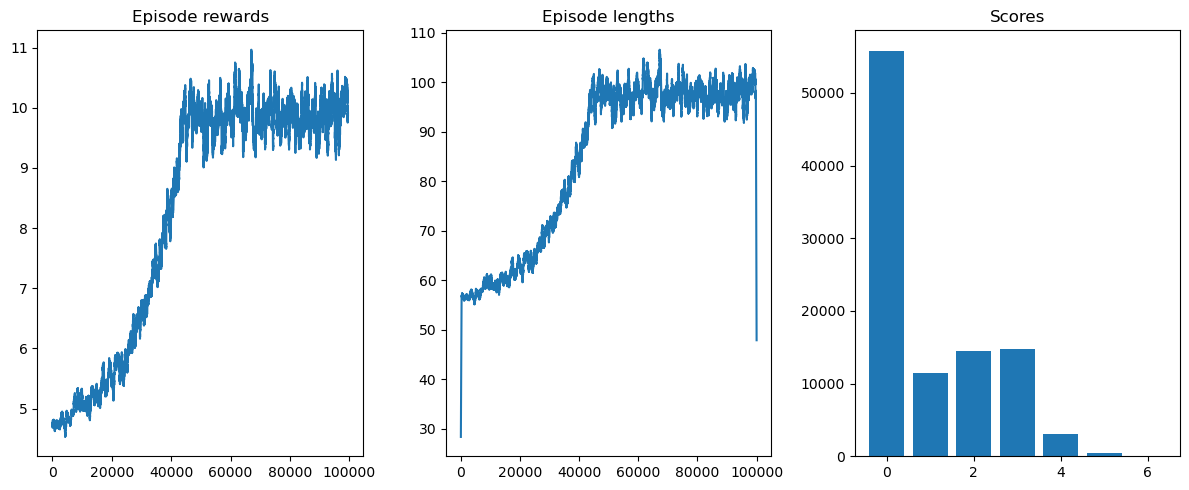

: 

In [34]:
plot_charts(env, agent, count_scores=count_scores)

In [23]:
# 0.1, 1-0.1 - Episode 290000,     Scores: {0: '0.95468', 1: '0.04369', 2: '0.00155', 3: '0.00008'}
# 0.001, 0.1-0.01 - Episode 90000, Scores: {0: '0.89219', 1: '0.04409', 2: '0.03902', 3: '0.02428', 4: '0.00041', 5: '0.00001'}
#                                          {0: '0.67719', 1: '0.08666', 2: '0.10239', 3: '0.12079', 4: '0.01239', 5: '0.00055', 6: '0.00002'}
#                  Episode 190000, Scores: {0: '0.52662', 1: '0.12152', 2: '0.16298', 3: '0.14976', 4: '0.03378', 5: '0.00519', 6: '0.00015'}

# Episode 390000, Scores: {0: '0.47200', 1: '0.12694', 2: '0.19445', 3: '0.15596', 4: '0.04044', 5: '0.00968', 6: '0.00050', 7: '0.00001'}


### Testing

In [22]:
num_episodes = 1000

# Initialize the environment with the loaded agent and rendering
test_env = gymnasium.make("FlappyBird-v0", use_lidar=False, render_mode = None)
test_env = gymnasium.wrappers.RecordEpisodeStatistics(test_env, deque_size=num_episodes)
test_env = gymnasium.wrappers.TransformReward(test_env, transform_reward)

loaded_agent = QLearningAgent(env=test_env)
loaded_agent.load("q-values-transform-4-800_000.pkl")

itr = 0
test_count_scores = {}
while itr < num_episodes:
    # play one episode
    accumulated_reward = 0
    obs, info = test_env.reset()
    done = False

    while not done:
        action = loaded_agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = test_env.step(action)
        accumulated_reward += reward

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        
    itr += 1
    score = info["score"]
    if not score in test_count_scores:
        test_count_scores[score] = 0
    test_count_scores[score] += 1
    
    # print(f"Episode {itr} | Score: {score} | Reward: {accumulated_reward}")
test_env.close()

/Users/batiukmaks/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.return_queue to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.return_queue` for environment variables or `env.get_wrapper_attr('return_queue')` that will search the reminding wrappers.
  logger.warn(
/Users/batiukmaks/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.length_queue to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.length_queue` for environment variables or `env.get_wrapper_attr('length_queue')` that will search the reminding wrappers.
  logger.warn(


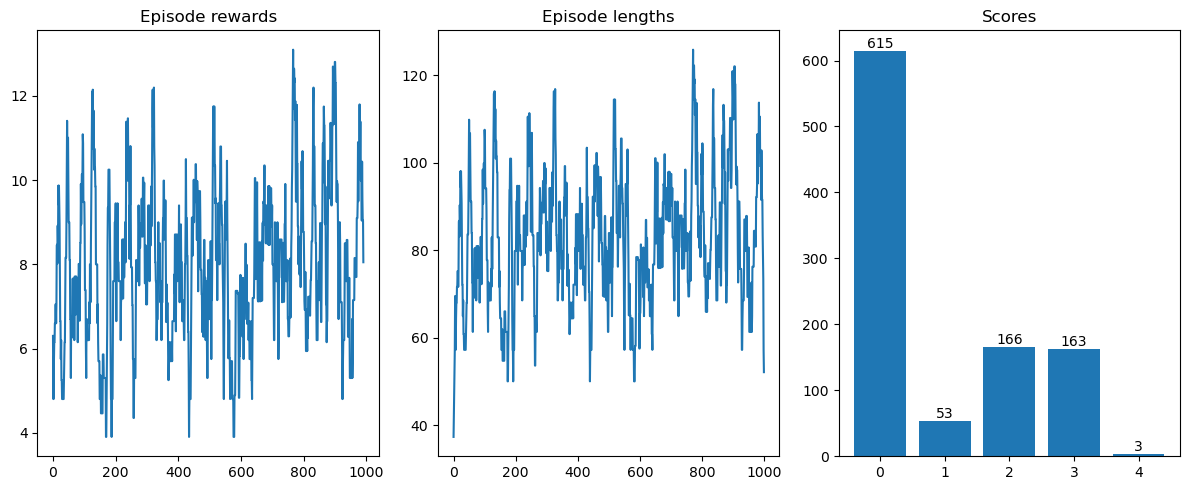

In [19]:
# 400k
plot_charts(test_env, loaded_agent, count_scores=test_count_scores, rolling_length=10) 

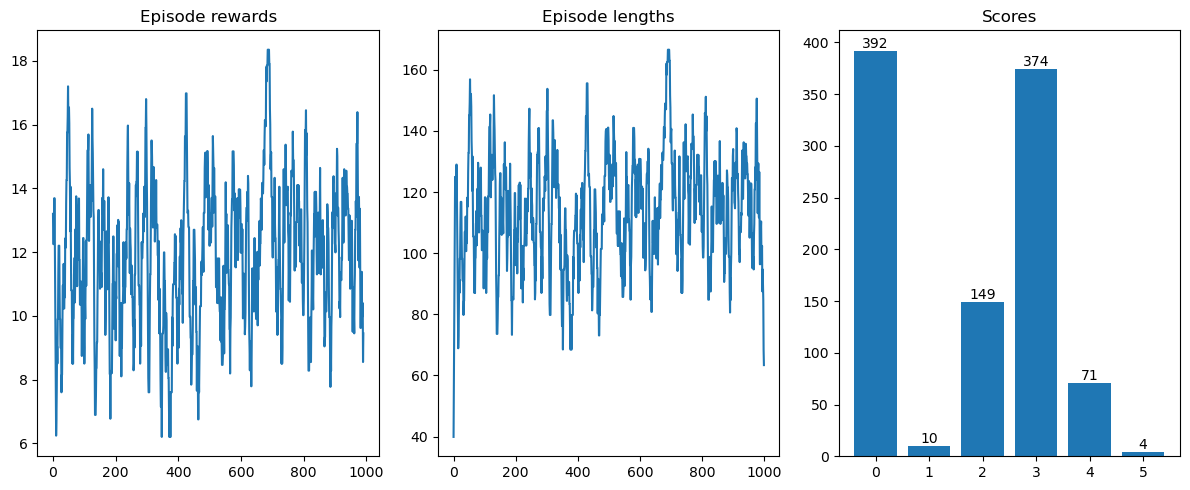

In [21]:
# 600k
plot_charts(test_env, loaded_agent, count_scores=test_count_scores, rolling_length=10) 

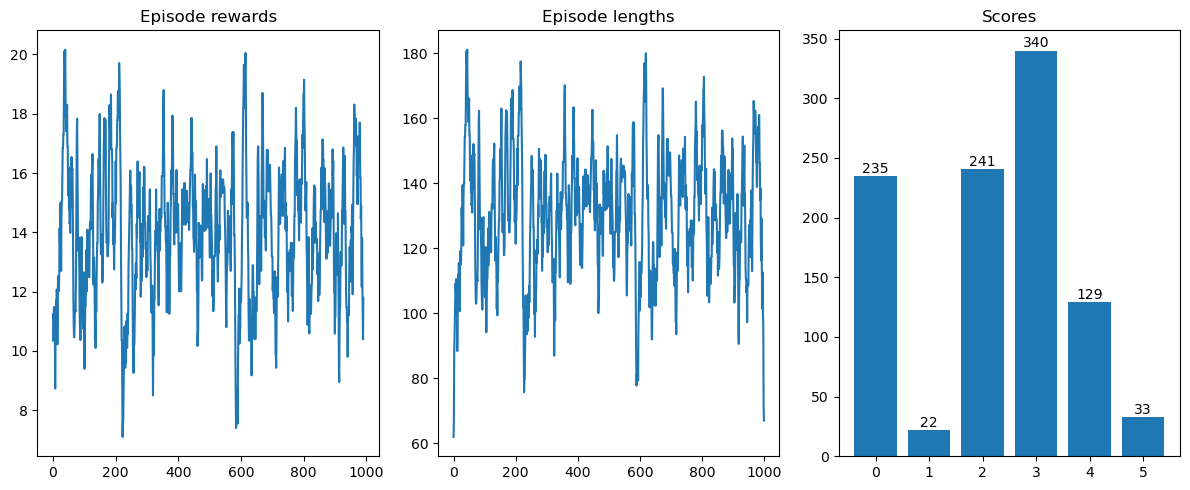

In [23]:
# 800k
plot_charts(test_env, loaded_agent, count_scores=test_count_scores, rolling_length=10) 

In [47]:
num_episodes = 10

# Initialize the environment with the loaded agent and rendering
test_env = gymnasium.make("FlappyBird-v0", use_lidar=False, render_mode = "human")
test_env = gymnasium.wrappers.RecordEpisodeStatistics(test_env, deque_size=num_episodes)
test_env = gymnasium.wrappers.TransformReward(test_env, transform_reward)

loaded_agent = QLearningAgent(env=test_env)
loaded_agent.load("q-values-transform-4-800_000.pkl")

itr = 0
test_count_scores = {}
while itr < num_episodes:
    # play one episode
    accumulated_reward = 0
    obs, info = test_env.reset()
    done = False

    while not done:
        action = loaded_agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = test_env.step(action)
        accumulated_reward += reward

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        
    itr += 1
    score = info["score"]
    if not score in test_count_scores:
        test_count_scores[score] = 0
    test_count_scores[score] += 1
    
    # print(f"Episode {itr} | Score: {score} | Reward: {accumulated_reward}")
test_env.close()

In [ ]:
# Чи є різниця чи використовувати трансформовані винагороди при тестуванні чи ні?
# Якщо хочеш щось дотренувати, то які епсилони ставити? 